# Project 3: Austrailia Rainfall Prediction

Mengyu Jackson

## Overview

Australia has a variety of weather stations across the country, which collect data used for rainfall forecasting.
Although basic metrics are recorded at all stations (Max Temperature, Minimum Temperature, Rainfall), other metrics are intermittently or never recorded at certain stations (such as amount of Sunshine, cloudiness, Evaporation, Pressure, etc.)

The Australian government wants to determine whether additional investment in recording these metrics will improve rainfall forecasting in these areas.

Our models (which match state of the art accuracy) are able to predict rainfall at stations which do not collect all metrics as well as stations which do record all metrics.

Spending more money to collect these metrics will not improve rainfall forecasting.

## Business Problem

Australia has a variety of weather stations across the country, which collect data used for rainfall forecasting.
Although basic metrics are recorded at all stations (Max Temperature, Minimum Temperature, Rainfall), other metrics are intermittently or never recorded at certain stations (such as amount of Sunshine, cloudiness, Evaporation, Pressure, etc.)

The Australian government wants to determine whether additional investment in recording these metrics will improve rainfall forecasting in these areas.

Rainfall forecasting is used for a variety of purposes by the public, and different uses are sensitive to different types of errors (false positive vs false negative) in forecasting. We need to evaluate model performance with and without all features on multiple types of errors.

If additional data is recommended, which data is most important?



## Data Understanding


In [1]:
!pip install --quiet --upgrade --user --upgrade-strategy=eager sktime

In [2]:
import pprint
import time

import numpy as np
import pandas as pd
from code.data_preparation import fit_predict, preprocess_data, preprocess_non_time_series, preprocess_time_series
from code.visualization import get_all_displays

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.panel.rocket import MiniRocket
from sktime.utils.data_processing import from_2d_array_to_nested

RANDOM_SEED = 0

In [3]:
weatherAUS = pd.read_csv('./data/weatherAUS.csv')

In [5]:
data_full = preprocess_data(weatherAUS.copy())

# Some extra pre-processing for methods which do not natively understand time series
data_full_trad = preprocess_non_time_series(data_full.copy())

C:\Users\steve\Documents\Flatiron\project_3\code\data_preparation.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RainToday"] = df["RainToday"].replace("No", 0).replace("Yes", 1).astype(float)
C:\Users\steve\Documents\Flatiron\project_3\code\data_preparation.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["RainTomorrow"] = (
C:\Users\steve\Documents\Flatiron\project_3\code\data_preparation.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [7]:
# Used for Time Series prediction

data_by_location = {
    loc: preprocess_time_series(data_full[data_full["Location"]==loc].copy())
    for loc in data_full["Location"].unique()
}

na_columns_by_loc = {}
for loc, df in data_by_location.items():
    na_columns_by_loc[loc] = [
        col for col in df.columns
        if all(df[col].isna())
    ]

for loc, na_columns in na_columns_by_loc.items():
    df = data_by_location[loc]
    for col in na_columns:
        df.pop(col)

na_columns_unique = sorted(set(sum(na_columns_by_loc.values(), [])))

print("Columns which are fully NaN for at least one Location:", na_columns_unique)

pprint.pprint(na_columns_by_loc)



Albury: ['Evaporation', 'Sunshine']
BadgerysCreek: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
Cobar: []
CoffsHarbour: []
Moree: []
Newcastle: ['Evaporation', 'Sunshine', 'WindGustSpeed', 'Pressure9am', 'Pressure3pm']
NorahHead: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
NorfolkIsland: []
Penrith: ['Evaporation', 'Sunshine', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
Richmond: ['Sunshine']
Sydney: []
SydneyAirport: []
WaggaWagga: []
Williamtown: []
Wollongong: ['Evaporation', 'Sunshine']
Canberra: []
Tuggeranong: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
MountGinini: ['Evaporation', 'Sunshine', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']
Ballarat: ['Evaporation', 'Sunshine']
Bendigo: ['Sunshine']
Sale: []
MelbourneAirport: []
Melbourne: []
Mildura: []
Nhil: ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']
Portland: []
Watsonia: []
Dartmoor: ['Cloud9am', 'Cloud3pm']
Brisbane: []
Cairns: []
GoldCoast: ['Evaporation', 'Sunshine', 'Cloud9a

In [9]:
# How good/bad are models trained without any Optional variables?

data_stripped_trad = data_full_trad.copy().drop(na_columns_unique, axis=1)
data_stripped_trad

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Latitude,Longitude,DayOfYear_Sin,DayOfYear_Cos,Year
0,Albury,13.4,22.9,0.6,W,W,WNW,20.0,24.0,71.0,22.0,16.9,21.8,0.0,0.0,36.0737,146.9135,-0.478734,0.877960,2008
1,Albury,7.4,25.1,0.0,WNW,NNW,WSW,4.0,22.0,44.0,25.0,17.2,24.3,0.0,0.0,36.0737,146.9135,-0.463550,0.886071,2008
2,Albury,12.9,25.7,0.0,WSW,W,WSW,19.0,26.0,38.0,30.0,21.0,23.2,0.0,0.0,36.0737,146.9135,-0.448229,0.893919,2008
3,Albury,9.2,28.0,0.0,NE,SE,E,11.0,9.0,45.0,16.0,18.1,26.5,0.0,0.0,36.0737,146.9135,-0.432776,0.901502,2008
4,Albury,17.5,32.3,1.0,W,ENE,NW,7.0,20.0,82.0,33.0,17.8,29.7,0.0,0.0,36.0737,146.9135,-0.417194,0.908818,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,3.5,21.8,0.0,E,ESE,E,15.0,13.0,59.0,27.0,9.4,20.9,0.0,0.0,25.3444,131.0369,0.196673,-0.980469,2017
145455,Uluru,2.8,23.4,0.0,E,SE,ENE,13.0,11.0,51.0,24.0,10.1,22.4,0.0,0.0,25.3444,131.0369,0.179767,-0.983709,2017
145456,Uluru,3.6,25.3,0.0,NNW,SE,N,13.0,9.0,56.0,21.0,10.9,24.5,0.0,0.0,25.3444,131.0369,0.162807,-0.986658,2017
145457,Uluru,5.4,26.9,0.0,N,SE,WNW,9.0,9.0,53.0,24.0,12.5,26.1,0.0,0.0,25.3444,131.0369,0.145799,-0.989314,2017


In [10]:
# Scale all numerical features to 0-1, Convert Categorical Features to 0s or 1s
column_transformer = make_column_transformer(
    (MinMaxScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(handle_unknown="ignore"),
     make_column_selector(dtype_include=object)))


In [11]:
# break down for train and test
X_train_trad_full = data_full_trad[data_full_trad['Year']<2016].copy()
y_train_trad_full = X_train_trad_full.pop('RainTomorrow')
X_test_trad_full = data_full_trad[data_full_trad['Year']>=2016].copy()
y_test_trad_full = X_test_trad_full.pop('RainTomorrow')


X_train_trad_stripped = data_stripped_trad[data_full_trad['Year']<2016].copy()
y_train_trad_stripped = X_train_trad_stripped.pop('RainTomorrow')
X_test_trad_stripped = data_stripped_trad[data_full_trad['Year']>=2016].copy()
y_test_trad_stripped = X_test_trad_stripped.pop('RainTomorrow')

# Linear Model

Training time: 11.938345432281494


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3b8481250>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3e4978ee0>)

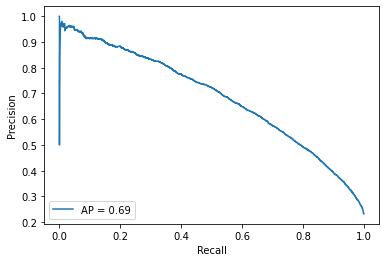

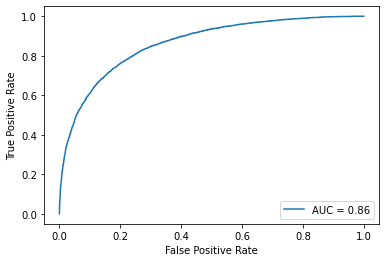

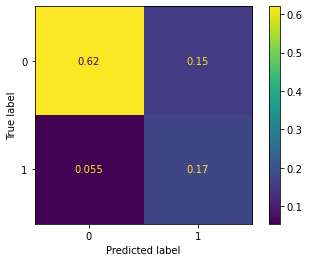

In [12]:
# Train Linear Model on Full data (all variables)

linear_clf_full = make_pipeline(
    column_transformer,
    SimpleImputer(), 
    LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_SEED,
    ),
)
start = time.time()
linear_summary_full = fit_predict(linear_clf_full, X_train_trad_full, y_train_trad_full, X_test_trad_full, y_test_trad_full)
training_time = time.time() - start
print(f"Training time: {training_time}")

get_all_displays(linear_summary_full)

Training time: 9.251675367355347


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3e4984fd0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3e4b386d0>)

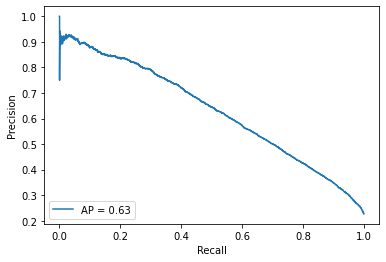

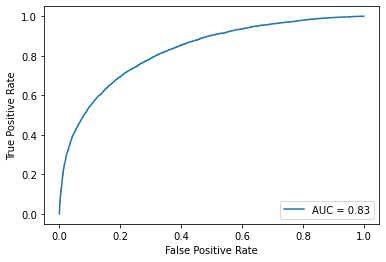

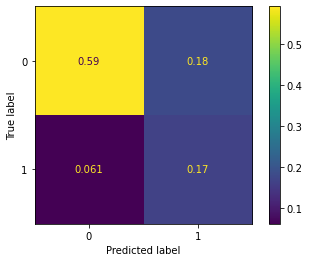

In [13]:
# Train Linear Model on Core/Stripped data (no optional variables)


linear_clf_stripped = make_pipeline(
    column_transformer,
    SimpleImputer(), 
    LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_SEED,
    ),
)
start = time.time()
linear_summary_stripped = fit_predict(linear_clf_stripped, X_train_trad_stripped, y_train_trad_stripped, X_test_trad_stripped, y_test_trad_stripped)
training_time = time.time() - start
print(f"Training time: {training_time}")
#linear_summary

get_all_displays(linear_summary_stripped)

# Ada Boost Model

(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3e4bf0a00>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3e4cb5130>)

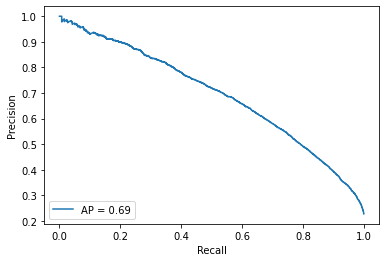

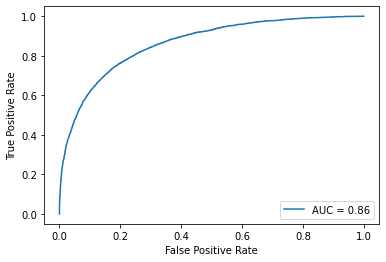

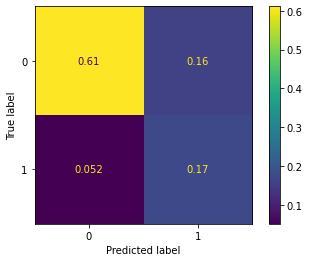

In [14]:
# Train Tree based Model on Full data (all variables)


ada_clf_full = make_pipeline(column_transformer,
                    SimpleImputer(), 
                    AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1, class_weight="balanced"), random_state=RANDOM_SEED)
                      )

ada_summary_full = fit_predict(ada_clf_full, X_train_trad_full, y_train_trad_full, X_test_trad_full, y_test_trad_full)

get_all_displays(ada_summary_full)

(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3e4d72f10>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3e761c490>)

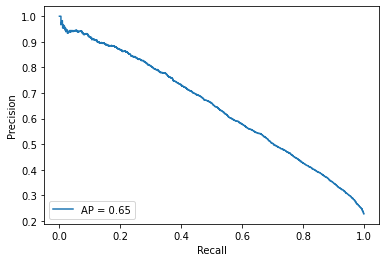

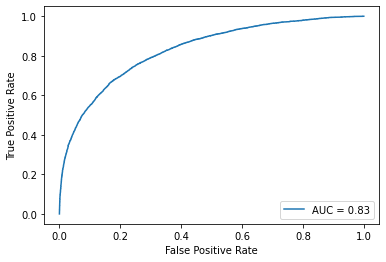

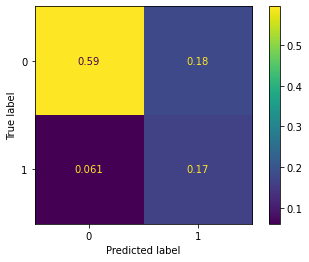

In [15]:
# Train Tree based Model on Core/Stripped data (no optional variables)


ada_clf_stripped = make_pipeline(column_transformer,
                    SimpleImputer(), 
                    AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1, class_weight="balanced"), random_state=RANDOM_SEED)
                      )

ada_summary_stripped = fit_predict(ada_clf_stripped, X_train_trad_stripped, y_train_trad_stripped, X_test_trad_stripped, y_test_trad_stripped)

get_all_displays(ada_summary_stripped)

## Interim Result

(Some of) the Optional metrics appear to be important. 
* Average Precision consistently drops by ~.05 when these columns are removed, for a variety of models
* AUC_ROC consistently drops by ~.03 when these columns are removed, for a variety of models

We need to drill down to specific locations to figure out which missing columns are actually problematic...

# Time Series (Location Specific) Models

In [16]:
# Create Test/Train data for each location

y_by_location, X_by_location = {}, {}

for loc, df in data_by_location.items():
    X_by_location[loc] = df.copy()
    y_by_location[loc] = X_by_location[loc].pop("RainTomorrow")
    X_by_location[loc].pop("Location")
    X_by_location[loc].pop("Latitude") # Constant for a single location
    X_by_location[loc].pop("Longitude") # Constant for a single location

X_train_by_loc, X_test_by_loc, y_train_by_loc, y_test_by_loc = {}, {}, {}, {}
for loc in data_by_location.keys():
    X_train_by_loc[loc], X_test_by_loc[loc], y_train_by_loc[loc], y_test_by_loc[loc] = temporal_train_test_split(X_by_location[loc], y_by_location[loc], train_size=.85)

In [17]:
# Same transform steps as Linear/Tree models, except "from_2d_array_to_nested" is necessary to format it for sktime models

transform_pipeline_by_loc = {
    loc: make_pipeline(
        make_column_transformer(
            (MinMaxScaler(),
             make_column_selector(dtype_include=np.number)),
            (OneHotEncoder(handle_unknown="ignore"),
             make_column_selector(dtype_include=object)), sparse_threshold=0),
        KNNImputer(),
        FunctionTransformer(from_2d_array_to_nested),
    )
    for loc in X_train_by_loc.keys()
}

In [18]:
X_train_transformed_by_loc = {
    loc: transform_pipeline.fit_transform(X_train_by_loc[loc])
    for loc, transform_pipeline in transform_pipeline_by_loc.items()
}

X_test_transformed_by_loc = {
    loc: transform_pipeline.transform(X_test_by_loc[loc])
    for loc, transform_pipeline in transform_pipeline_by_loc.items()
}

In [19]:
for loc, X_train_transformed in X_train_transformed_by_loc.items():
    X_train_transformed.index = X_train_by_loc[loc].index
    
for loc, X_test_transformed in X_test_transformed_by_loc.items():
    X_test_transformed.index = X_test_by_loc[loc].index

In [54]:
# Train for each location
# Mini Rocket is supposed to be very good, but also the only time series model that finishes in reasonable time

start = time.time()

inference_pipeline_by_loc = {
    loc: make_pipeline(
        MiniRocket(random_state=RANDOM_SEED), 
        RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    )
    for loc in X_train_transformed_by_loc.keys()
}

summary_by_loc = {
    loc: fit_predict(inference_pipeline, X_train_transformed_by_loc[loc], y_train_by_loc[loc], X_test_transformed_by_loc[loc], y_test_by_loc[loc])
    for loc, inference_pipeline in inference_pipeline_by_loc.items()
}
    
training_time = time.time() - start9
print(f"Training took {training_time} seconds")

Training took 222.82181358337402 seconds


              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     16148
         1.0       0.74      0.52      0.61      4990

    accuracy                           0.84     21138
   macro avg       0.80      0.73      0.75     21138
weighted avg       0.83      0.84      0.83     21138



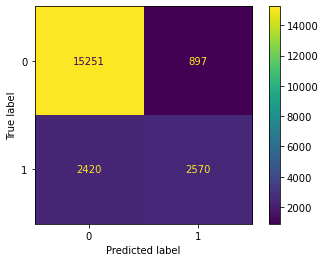

In [55]:
combined_y_test = sum((list(v) for v in y_test_by_loc.values()), [])
combined_y_pred = sum((list(s["y_pred"]) for s in summary_by_loc.values()), [])
combined_confusion = confusion_matrix(combined_y_test, combined_y_pred)

disp2 = ConfusionMatrixDisplay(combined_confusion)
disp2.plot() 
print(classification_report(combined_y_test, combined_y_pred))

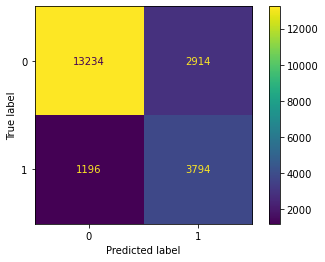

In [56]:
# Examine Confusion Matrix if we use different cutoff try to improve True Positive cases
# This makes the confusion matrices more comparable to the models trained above

combined_y_decision = sum((list(1 if d > -.4 else 0 for d in s["decision_function"]) for s in summary_by_loc.values()), [])

combined_confusion = confusion_matrix(combined_y_test, combined_y_decision)

disp3 = ConfusionMatrixDisplay(combined_confusion)
disp3.plot() 

In [57]:
print(classification_report(y_test_trad_full, linear_summary_full["y_pred"]))
print(classification_report(y_test_trad_full, ada_summary_full["y_pred"]))
print(classification_report(combined_y_test, combined_y_decision))

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.86     19885
         1.0       0.53      0.76      0.62      5825

    accuracy                           0.79     25710
   macro avg       0.72      0.78      0.74     25710
weighted avg       0.83      0.79      0.80     25710

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85     19885
         1.0       0.52      0.77      0.62      5825

    accuracy                           0.79     25710
   macro avg       0.72      0.78      0.74     25710
weighted avg       0.83      0.79      0.80     25710

              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     16148
         1.0       0.57      0.76      0.65      4990

    accuracy                           0.81     21138
   macro avg       0.74      0.79      0.76     21138
weighted avg       0.83      0.81      0.81     21138



## Note:

The Location Specific Time Series Models have combined metrics better than either the LogisticRegression or AdaBoost models in almost every aspect:

* Negative class Precision and Recall are equal or better
* Positive class Precision is better and recall is close. 
* F1 scores are better
* Macro averages for precision recall and f1 score are all better.
* Weighted averages for precision, recall, and f1-score are equal or better than earlier models.

In [66]:
avg_precision_by_loc = {loc: s["average_precision_score"] for loc, s in summary_by_loc.items()}

roc_auc_score_by_loc = {loc: s["roc_auc_score"] for loc, s in summary_by_loc.items()}

print("Average Precision by location:\n", pd.Series(avg_precision_by_loc.values()).describe())
print("\nROC AUC by location:\n", pd.Series(roc_auc_score_by_loc.values()).describe())

Average Precision by location:
 count    49.000000
mean      0.701341
std       0.091339
min       0.482133
25%       0.650952
50%       0.705508
75%       0.756792
max       0.877215
dtype: float64

ROC AUC by location:
 count    49.000000
mean      0.862254
std       0.041353
min       0.705093
25%       0.835185
50%       0.867109
75%       0.885991
max       0.944724
dtype: float64


In [67]:
avg_precision_by_loc_na_columns = {loc: s["average_precision_score"] for loc, s in summary_by_loc.items() if na_columns_by_loc[loc]}
roc_auc_score_by_loc_na_columns = {loc: s["roc_auc_score"] for loc, s in summary_by_loc.items() if na_columns_by_loc[loc]}
avg_precision_by_loc_no_na_columns = {loc: s["average_precision_score"] for loc, s in summary_by_loc.items() if not na_columns_by_loc[loc]}
roc_auc_score_by_loc_no_na_columns = {loc: s["roc_auc_score"] for loc, s in summary_by_loc.items() if not na_columns_by_loc[loc]}

In [68]:
pd.DataFrame({
    "Avg Precision w/NAs": pd.Series(avg_precision_by_loc_na_columns.values()).describe(),
    "Avg Precision w/o NAs": pd.Series(avg_precision_by_loc_no_na_columns.values()).describe(),
})

,Avg Precision w/NAs,Avg Precision w/o NAs
count,23.000000,26.000000
mean,0.717355,0.687174
std,0.086763,0.094599
min,0.482133,0.498253
25%,0.681913,0.628387
50%,0.714233,0.701733
75%,0.772585,0.742530
max,0.877215,0.832416


In [69]:
pd.DataFrame({
    "ROC AUC w/NAs": pd.Series(roc_auc_score_by_loc_na_columns.values()).describe(),
    "ROC AUC w/o NAs": pd.Series(roc_auc_score_by_loc_no_na_columns.values()).describe(),
})

,ROC AUC w/NAs,ROC AUC w/o NAs
count,23.000000,26.000000
mean,0.863457,0.861190
std,0.048863,0.034349
min,0.705093,0.799104
25%,0.834912,0.836227
50%,0.867109,0.862786
75%,0.893077,0.883871
max,0.944724,0.929656


## Surprising Result

The Location Specific Time Series models are better for locations which do not record at least one Optional metric:
* Mean, min, 25%, 75% and max avg_precision are all better
* 50% avg_precision is nearly identical
* mean, 25%, 50%, 75%, and max ROC AUC are all better

The minimum ROC AUC is much lower however (.70 vs .79).

Looking at this outlier gives us a key insight:

In [70]:
print("Three worst ROC AUC scores in locations which do not record at least one Optional metric:\n")
pprint.pprint(sorted((roc_auc_score, loc, na_columns_by_loc[loc]) for loc, roc_auc_score in roc_auc_score_by_loc.items() if na_columns_by_loc[loc])[:2])

Three worst ROC AUC scores in locations which do not record at least one Optional metric:

[(0.7050934862147447,
  'Newcastle',
  ['Evaporation', 'Sunshine', 'WindGustSpeed', 'Pressure9am', 'Pressure3pm']),
 (0.8126399095534201, 'Albany', ['WindGustSpeed'])]


In [71]:
print([loc for loc, na_columns in na_columns_by_loc.items() if "WindGustSpeed" in na_columns])

['Newcastle', 'Albany']


### Key Insight
* Newcastle is by far the worst ROC AUC score of any location specific classifier. 
* Albany is the second worst out of all sites missing a column. It would be <25% in either group of locations
* These are the only two sites which do not record the WindGustSpeed Optional metric



In [72]:
avg_precision_by_loc_na_wind_columns = {loc: s["average_precision_score"] for loc, s in summary_by_loc.items() if na_columns_by_loc[loc] and "WindGustSpeed" not in na_columns_by_loc[loc]}

roc_auc_score_by_loc_na_wind_columns = {loc: s["roc_auc_score"] for loc, s in summary_by_loc.items() if na_columns_by_loc[loc] and "WindGustSpeed" not in na_columns_by_loc[loc]}

print("Average Precision by location non-Wind NAs:\n", pd.Series(avg_precision_by_loc_na_wind_columns.values()).describe())
print("\nROC AUC by location non-Wind NAs:\n", pd.Series(roc_auc_score_by_loc_na_wind_columns.values()).describe())

Average Precision by location non-Wind NAs:
 count    21.000000
mean      0.728565
std       0.073364
min       0.605664
25%       0.681929
50%       0.714233
75%       0.772980
max       0.877215
dtype: float64

ROC AUC by location non-Wind NAs:
 count    21.000000
mean      0.873418
std       0.033750
min       0.823143
25%       0.852611
50%       0.872085
75%       0.894222
max       0.944724
dtype: float64


In [73]:
pd.DataFrame({
    "Avg Precision w/NAs  (excluding wind)": pd.Series(avg_precision_by_loc_na_wind_columns.values()).describe(),
    "Avg Precision w/o NAs": pd.Series(avg_precision_by_loc_no_na_columns.values()).describe(),
})

,Avg Precision w/NAs (excluding wind),Avg Precision w/o NAs
count,21.000000,26.000000
mean,0.728565,0.687174
std,0.073364,0.094599
min,0.605664,0.498253
25%,0.681929,0.628387
50%,0.714233,0.701733
75%,0.772980,0.742530
max,0.877215,0.832416


In [74]:
pd.DataFrame({
    "ROC AUC w/NAs (excluding wind)": pd.Series(roc_auc_score_by_loc_na_wind_columns.values()).describe(),
    "ROC AUC w/o NAs": pd.Series(roc_auc_score_by_loc_no_na_columns.values()).describe(),
})

,ROC AUC w/NAs (excluding wind),ROC AUC w/o NAs
count,21.000000,26.000000
mean,0.873418,0.861190
std,0.033750,0.034349
min,0.823143,0.799104
25%,0.852611,0.836227
50%,0.872085,0.862786
75%,0.894222,0.883871
max,0.944724,0.929656


['confusion_matrix', 'display_labels', '__module__', '__doc__', '__init__', 'plot', '__dict__', '__weakref__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


Text(0.5, 1.0, 'True vs Predicted Rainfall\nLocations with Full Metrics')

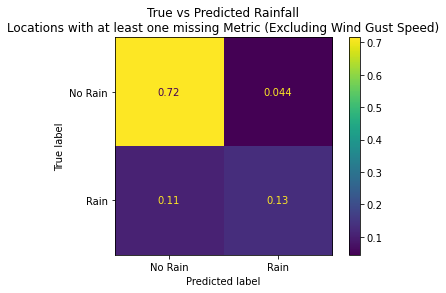

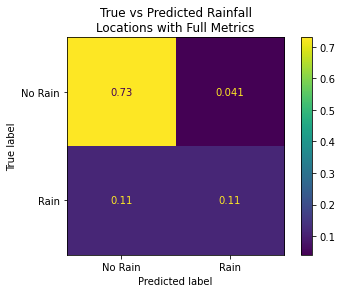

In [77]:
# Let's look at the Confusion Matrix for predictions in these categories: "Full" Locations vs "Core + Wind" Locations w/ NAs

combined_y_test_wind_nas = sum((list(v) 
                                for loc, v in y_test_by_loc.items() 
                                if na_columns_by_loc[loc] and "WindGustSpeed" not in na_columns_by_loc[loc]), [])
combined_y_pred_wind_nas = sum((list(s["y_pred"]) 
                                for loc, s in summary_by_loc.items()
                                if na_columns_by_loc[loc] and "WindGustSpeed" not in na_columns_by_loc[loc]), [])
combined_confusion_wind_nas = confusion_matrix(combined_y_test_wind_nas, combined_y_pred_wind_nas, normalize="all")

disp_wind_nas = ConfusionMatrixDisplay(combined_confusion_wind_nas, display_labels=["No Rain", "Rain"])

print(disp_wind_nas.__dir__())
plt_wind_nas = disp_wind_nas.plot(values_format=".3g") 
plt_wind_nas.ax_.set_title("True vs Predicted Rainfall\nLocations with at least one missing Metric (Excluding Wind Gust Speed)")


combined_y_test_no_nas = sum((list(v) 
                                for loc, v in y_test_by_loc.items()
                                if not na_columns_by_loc[loc]), [])
combined_y_pred_no_nas = sum((list(s["y_pred"]) 
                              for loc, s in summary_by_loc.items()
                              if not na_columns_by_loc[loc]), [])
combined_confusion_no_nas = confusion_matrix(combined_y_test_no_nas, combined_y_pred_no_nas, normalize="all")

disp_no_nas = ConfusionMatrixDisplay(combined_confusion_no_nas, display_labels=["No Rain", "Rain"])
plt_no_nas = disp_no_nas.plot(values_format=".2g") 
plt_no_nas.ax_.set_title("True vs Predicted Rainfall\nLocations with Full Metrics")


# Final Time Series Results

WindGustSpeed is the only Optional metric that seriously improved the Location Specific Time Series Models (or made them worse when it was missing).

Rainfall predictions for locations missing one or more of the other metrics actually did *better* than predictions for locations with full Optional metrics (this is a good subject for future investigation).

We don't want to assume the Australian government will only ever use Location Specific Time Series models, so we'll check our earlier models. We want to see if "Core+WindGustSpeed" models (trained on all Core features + WindGustSpeed) does better than the Core models (trained on Core features with no Optional features) and is close to the "Full" models (trained on all Core + Optional features)

# Adding Back in WindGustSpeed


In [34]:
X_train_trad_wind = X_train_trad_stripped.copy()
X_test_trad_wind = X_test_trad_stripped.copy()
y_train_trad_wind = y_train_trad_stripped.copy()
y_test_trad_wind = y_test_trad_stripped.copy()

X_train_trad_wind["WindGustSpeed"] = X_train_trad_full["WindGustSpeed"].copy()
X_test_trad_wind["WindGustSpeed"] = X_test_trad_full["WindGustSpeed"].copy()

Training time: 9.203127145767212


(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3e4d528e0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3fe260760>)

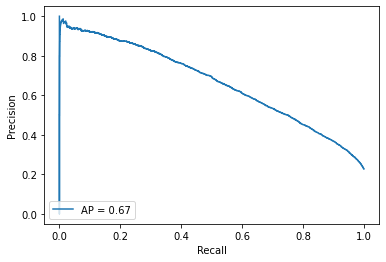

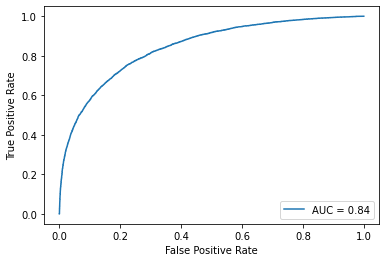

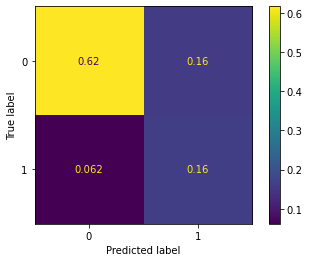

In [35]:
# Train Linear classifier on Core  variables + WindGustSpeed
linear_clf_wind = make_pipeline(
    column_transformer,
    SimpleImputer(), 
    LinearSVC(
        class_weight="balanced",
        random_state=RANDOM_SEED,
    ),
)
start = time.time()
linear_summary_wind = fit_predict(linear_clf_wind, X_train_trad_wind, y_train_trad_wind, X_test_trad_wind, y_test_trad_wind)
training_time = time.time() - start
print(f"Training time: {training_time}")

get_all_displays(linear_summary_wind)

(<sklearn.metrics._plot.precision_recall_curve.PrecisionRecallDisplay at 0x2c3fe3215b0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2c3fe3c8a30>)

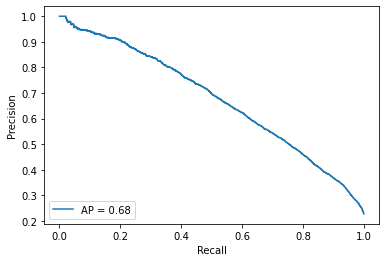

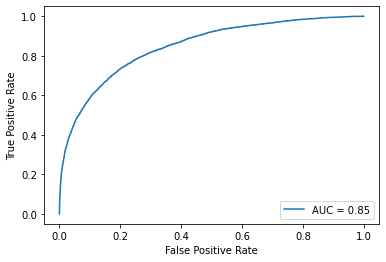

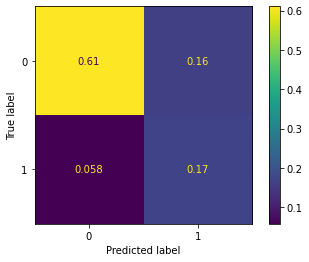

In [36]:
# Train Tree Based classifier on Core  variables + WindGustSpeed

ada_clf_wind = make_pipeline(column_transformer,
                    SimpleImputer(), 
                    AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=1, class_weight="balanced"), random_state=RANDOM_SEED)
                      )

ada_summary_wind = fit_predict(ada_clf_wind, X_train_trad_wind, y_train_trad_wind, X_test_trad_wind, y_test_trad_wind)

get_all_displays(ada_summary_wind)

In [37]:
# Compare Linear models using Core, Core + Wind, or Full data


print("Linear Model:")
pd.DataFrame({
    "Core": {
        "ROC_AUC": linear_summary_stripped["roc_auc_score"], 
        "Average_Precision": linear_summary_stripped["average_precision_score"]},
    "Core+Wind": {
        "ROC_AUC": linear_summary_wind["roc_auc_score"], 
        "Average_Precision": linear_summary_wind["average_precision_score"]},
    "Full": {
        "ROC_AUC": linear_summary_full["roc_auc_score"], 
        "Average_Precision": linear_summary_full["average_precision_score"]},
        },
)

Linear Model:


,Core,Core+Wind,Full
ROC_AUC,0.827815,0.844643,0.862450
Average_Precision,0.630241,0.665506,0.686304


In [38]:
# Compare Tree based models using Core, Core + Wind, or Full data


print("AdaBoost Model:")
pd.DataFrame({
    "Core": {
        "ROC_AUC": ada_summary_stripped["roc_auc_score"], 
        "Average_Precision": ada_summary_stripped["average_precision_score"]},
    "Core+Wind": {
        "ROC_AUC": ada_summary_wind["roc_auc_score"], 
        "Average_Precision": ada_summary_wind["average_precision_score"]},
    "Full": {
        "ROC_AUC": ada_summary_full["roc_auc_score"], 
        "Average_Precision": ada_summary_full["average_precision_score"]},
        },
)

AdaBoost Model:


,Core,Core+Wind,Full
ROC_AUC,0.830956,0.847496,0.862973
Average_Precision,0.645311,0.677190,0.693929


# Final Final Result

The Linear model improves from .63 to .67